# Colab commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!cp /content/drive/MyDrive/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_prices.csv /content
!mkdir /content/models

In [ ]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [67]:
device

'mps'

# Load datasets

In [68]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

# Create class for collecting data

In [69]:
class StatuePriceDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor([labels[1]]).float().to(device)
        status = torch.tensor([labels[0]]).float().to(device)

        features = torch.cat([features, price])

        return features, status

    def __len__(self):
        return len(self.features)

In [70]:
temp = StatuePriceDataset(features, labels)
in_features = len(temp[0][0])
in_features

52

# Build model

In [53]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        # Load model for predicting prices and freeze its parameters
        filename = "models/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth"
        self.price = torch.load(filename, map_location=torch.device("cpu"))
        for param in self.price.parameters():
            param.requires_grad = False

        self.hidden = nn.Sequential(nn.Linear(in_features+ 1, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(128, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        pred_price = self.price(x[:, :-1])[:, None]

        new_features = torch.cat([x, pred_price], 1)
        out = self.hidden(new_features)
        out = self.status(out)

        return out

In [51]:
model = PredictStatus(in_features)
torchinfo.summary(model, input_size=(16, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictStatus                            [16, 1]                   --
├─PredictPrice: 1-1                      [16]                      --
│    └─Sequential: 2-1                   [16, 128]                 --
│    │    └─Linear: 3-1                  [16, 128]                 6,656
│    │    └─ReLU: 3-2                    [16, 128]                 --
│    │    └─Linear: 3-3                  [16, 128]                 16,512
│    │    └─ReLU: 3-4                    [16, 128]                 --
│    │    └─Linear: 3-5                  [16, 256]                 33,024
│    │    └─ReLU: 3-6                    [16, 256]                 --
│    │    └─Linear: 3-7                  [16, 128]                 32,896
│    │    └─ReLU: 3-8                    [16, 128]                 --
│    └─Sequential: 2-2                   [16, 1]                   --
│    │    └─Linear: 3-9                  [16, 1]                   129

In [52]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

temp_data = StatuePriceDataset(features, labels)
temp_loader = DataLoader(temp_data, batch_size=16)

x, y = next(iter(temp_loader))
x = x.to("cpu")
yhat = model(x)
writer.add_graph(model, x)

# Data standardization

In [9]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

# Train the model
## Prepare data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

# Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatuePriceDataset(train_feature, train_label)
    val_data = StatuePriceDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_feature["Sale or Let"].values)
    val_sampler = create_weighted_sampler(val_feature["Sale or Let"].values)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_removed_full_epoch_1000_fold_{}.pth".format(fold))



-------------This is fold 0----------------


# Testing performance

In [11]:
filename = "models/status_removed_full_epoch_1000_fold_4.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatuePriceDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

In [12]:
pred

,pred_completed,Truth
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
895,1.0,1.0
896,1.0,0.0
897,1.0,0.0
898,1.0,1.0


In [13]:
labels = pd.read_csv("../datasets/final_labels.csv")
sale_rent = torch.tensor(labels["Completed"].values)
classes, count = sale_rent.unique(return_counts=True)
classes, count

(tensor([0, 1]), tensor([3088, 6089]))

# Add weighted sampler
## Prepare data
### Load datasets

In [11]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

### Data standardization

In [12]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

### Split dataset

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

### Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatuePriceDataset(train_feature, train_label)
    val_data = StatuePriceDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_ws_removed_full_epoch_1000_fold_{}.pth".format(fold))

### Test performance (weighted sampler)

In [26]:
filename = "models/status_ws_removed_full_epoch_1000_fold_3.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatuePriceDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

In [27]:
pred

,pred_completed,Truth
0,0.499189,0.0
1,0.499189,1.0
2,0.499189,1.0
3,0.499189,1.0
4,0.499189,1.0
...,...,...
895,0.499189,1.0
896,0.499189,0.0
897,0.499189,0.0
898,0.499189,1.0


# Load model without freezing parameters
## Build model

In [59]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        # Load model for predicting prices and freeze its parameters
        filename = "models/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth"
        self.price = torch.load(filename, map_location=torch.device("cpu"))
        for param in self.price.parameters():
            pass
            # param.requires_grad = False

        self.hidden = nn.Sequential(nn.Linear(in_features+ 1, 256),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.Dropout(0.5),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(64, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        pred_price = self.price(x[:, :-1])[:, None]

        new_features = torch.cat([x, pred_price], 1)
        hidden = self.hidden(new_features)
        out = self.status(hidden)

        return out

## Load datasets

In [60]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

## Data standardization

In [61]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split datasets

In [62]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatuePriceDataset(train_feature, train_label)
    val_data = StatuePriceDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_ws_removed_full_no_freeze_fold_{}.pth".format(fold))



-------------This is fold 0----------------


## Test performance (no freezing)

In [63]:
filename = "models/status_ws_removed_full_no_freeze_fold_2.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatuePriceDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

In [64]:
pred

,pred_completed,Truth
0,0.498971,0.0
1,0.498971,1.0
2,0.498971,1.0
3,0.498971,1.0
4,0.498971,1.0
...,...,...
895,0.498971,1.0
896,0.498971,0.0
897,0.498971,0.0
898,0.498971,1.0


# Predict status (append predicted prices)
## Load model for predicting prices

In [71]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

## Load datasets

In [72]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

## Data standardization

In [73]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Predict prices

In [74]:
filename = "models/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth"
model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(features)):
    feature = torch.tensor((features.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": labels["Price / Rent"]})

In [75]:
pred

,PredictPrice,Price
0,625.755737,600.0
1,389552.875000,380000.0
2,474756.718750,475000.0
3,733.294800,625.0
4,880.092651,695.0
...,...,...
8990,769.316284,1200.0
8991,334037.187500,340000.0
8992,449794.281250,450000.0
8993,689.302612,750.0


## Merge prices

In [76]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

In [77]:
features["Predict Price"] = pred["PredictPrice"]
features

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,RTD3316_condition1 - Condition Description,# of Enquiry or viewings,# of Apps/Offers,bedroom number,kitchen number,living number,...,Eco-Friendly,Electric,Gas,Gas Central,Night Storage,Oil,Solar,Solar Water,Under Floor,Predict Price
0,3610,0,3,1,1,0.0,6.0,2,1,1,...,0,0,0,1,0,0,0,0,0,625.755737
1,3647,1,7,3,1,0.0,4.0,3,1,0,...,0,0,0,1,0,0,0,0,0,389552.875000
2,3650,1,7,4,1,0.0,1.0,4,1,0,...,0,0,0,1,0,0,0,0,0,474756.718750
3,3620,0,3,0,1,0.0,7.0,2,1,1,...,0,0,0,1,0,0,0,0,0,733.294800
4,3596,0,3,1,1,0.0,3.0,3,1,1,...,0,0,0,1,0,0,0,0,0,880.092651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,4476,0,3,3,1,0.0,0.0,3,1,2,...,0,0,0,1,0,0,0,0,0,769.316284
8991,4443,1,6,3,1,0.0,1.0,3,1,1,...,0,0,0,1,0,0,0,0,0,334037.187500
8992,4458,1,6,5,1,0.0,0.0,4,1,0,...,0,0,1,1,0,0,0,0,0,449794.281250
8993,547,0,3,0,1,0.0,2.0,1,1,0,...,0,0,1,1,0,0,0,0,0,689.302612


In [78]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.5),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(64, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        hidden = self.hidden(x)
        out = self.status(hidden)

        return out

In [80]:
temp = StatuePriceDataset(features, labels)
in_features = len(temp[0][0])
in_features

53

## Data standardization

In [16]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split datasets

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatuePriceDataset(train_feature, train_label)
    val_data = StatuePriceDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_append_ws_removed_full_no_freeze_fold_{}.pth".format(fold))

## Test performance (append predictions)

In [18]:
filename = "models/status_append_ws_removed_full_no_freeze_fold_2.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatuePriceDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    pred_com = torch.where(pred_com > 0.5, 1.0, 0.0)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

In [19]:
pred

,pred_completed,Truth
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0
...,...,...
895,1.0,1.0
896,1.0,0.0
897,1.0,0.0
898,1.0,1.0


In [81]:
classes, count = np.unique(labels["Completed"].values, return_counts=True)
classes, count

(array([0, 1]), array([2905, 6090]))

[Text(0, 0.5, 'Completed'), Text(0, 1.5, 'Not Completed')]

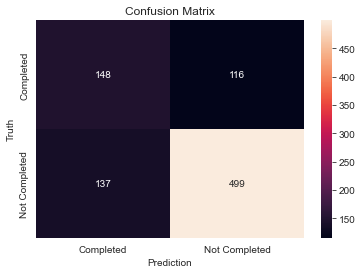

In [21]:
cm = confusion_matrix(pred["pred_completed"], pred["Truth"])
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Completed', 'Not Completed'])
ax.yaxis.set_ticklabels(['Completed', 'Not Completed'])

In [128]:
print("Accuracy: ", accuracy_score(pred["pred_completed"], pred["Truth"]))
print("Precision: ", precision_score(pred["pred_completed"], pred["Truth"]))
print("Recall: ", recall_score(pred["pred_completed"], pred["Truth"]))
print("F1 score:", f1_score(pred["pred_completed"], pred["Truth"]))

Accuracy:  0.7188888888888889
Precision:  0.8113821138211382
Recall:  0.7845911949685535
F1 score: 0.797761790567546
